# f-AnoGAN

**Implementacja na podstawie poniższych źródeł:**


*   https://www.sciencedirect.com/science/article/abs/pii/S1361841518302640
*   https://github.com/tSchlegl/f-AnoGAN

*   https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/wgan_gp/wgan_gp.py
*   https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/dcgan/dcgan.py

*   https://github.com/A03ki/f-AnoGAN











#I. Wstęp

## I.I Zasada działania
Rozwiązanie opiera się na dwóch blokach: ***Sieci GAN*** (Generator + Dyskryminator) oraz głębokiego enkodera ***(Deep Encoder)***

### A. GAN
Sama sieć GAN trenowana jest na próbkach bez anomalii - klasa OK.

- **Generator** trenowany jest do przekształcania losowego wektora wejściowego - mogącego być utożsamianym z losowym zdjęciem w przestrzeni ukrytej ***(latent space)*** - do zdjęcia reprezentującego klasę obiektu bez anomali. Na podstawie "feedbacku" od dyskryminatora.

- **Dyskryminator** porównuje i ocenia zdjęcie treningowe (prawdziwe zdjęcie bez anomalii) ze zdjęciem wygenerowanym przez generator.


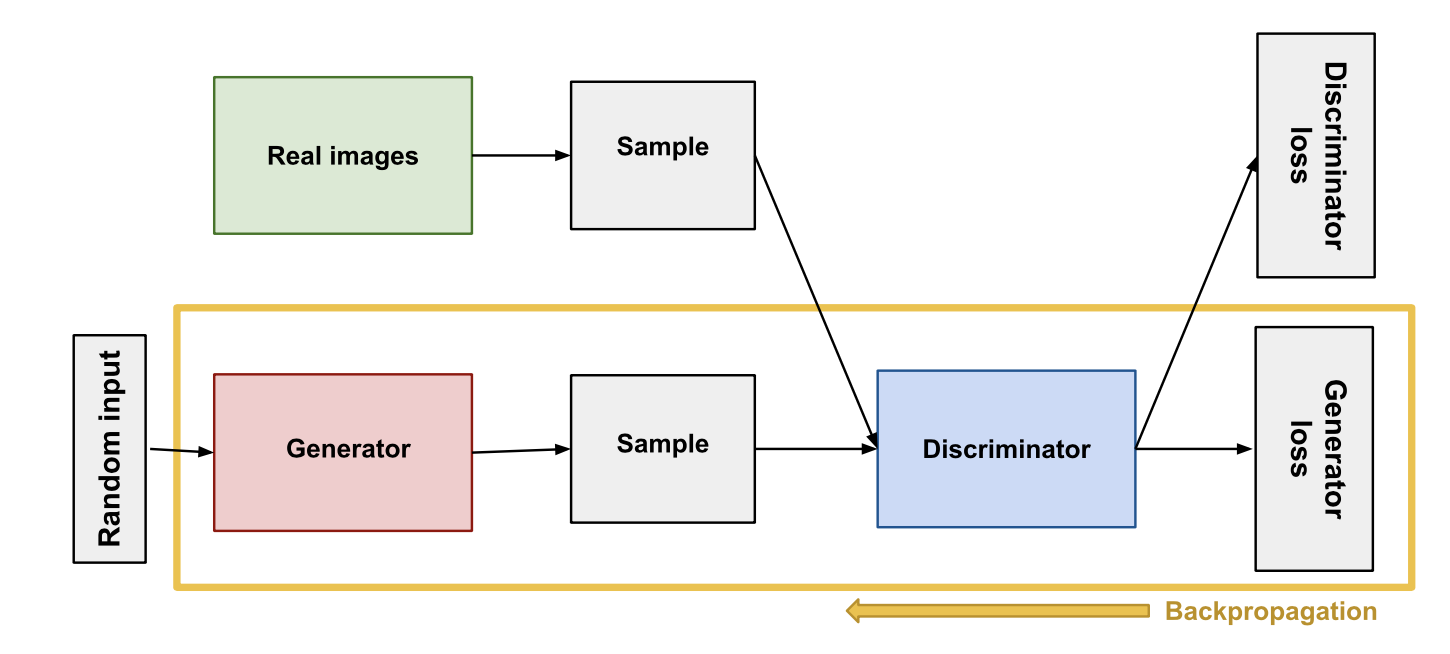

**Różnica między klasycznym GAN'em a zastosowanym tutaj WGAN'em znajduje się w dyskryminatorze i jest następująca:**

Zamiast wykorzystania dyskryminatora do klasyfikacji lub predykcji prawdopodobieństwa wygenererowane zdjęcia jako 'real' lub 'fake' stosowana jest miara prawdziwości badanego zdjęcia.

### B. Deep Encoder

Aby możliwa była detekcja anomalii (wskazanie ich) na zdjęciach wyjściowych, rozwiązanie oprócz sieci GAN wykorzystuje doatkowy encoder - mapujący zdjęcia do przestrzeni ukrytej (latent space). 

Trening encodera może przebiegać w trzech różnych reżimach:
- *image-z-image (izi) 
- z-image-z(ziz) 
- izi_f

^^gdzie ***'z'*** oznacza przestrzeń ukrytą a ***'image'*** przestrzeń zdjęcia



**1.**   ***image-z-image***


Ta architkeruta zakłada wytępujący po sobie układ ***ENCODER -> DECODER***(nasz generator z GAN'a). Trening **tylko na zdjęciach prawdziwych**.

Trening polega na tym, że na wejście enkodera dajemy 'prawdziwe' zdjęcie treningowe. Na jego wyjściu uzyskujemy reprezentację zdjęcia w przestrzeni ukrytej. Wyjście encodera od razu przepuszczamy przez wytrenowaną część generatora (dekoder) i ponownie otrzymujemy zdjęcie. Porównujemy tak otrzymane zdjęcie ze zdjęciem 'prawdziwym' i obliczamy **MSE**.

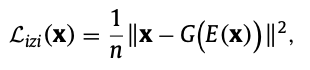


Schemat:

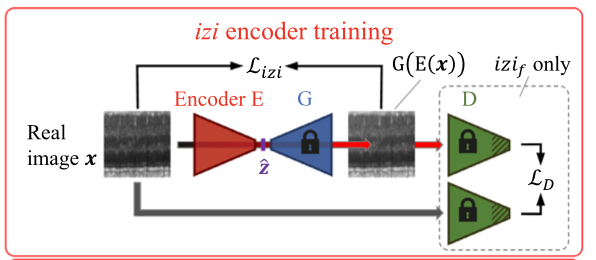





**2.**   ***z-image-z***

Trening polega na tym, że podczas treningu GAN'a podbieramy w losowych odstępach czasu tensor przestrzeni ukrytej. Wykorzystujemy dekoder (generator) do przetransformowania go do przestrzeni zdjęcia. Zdjęcie to jest wejściem do enkodera, który próbuje przekształcić go z powrotem do przestrzeni ukrytej.
Liczymy **MSE** między tensorem 'prawdziwym' (wejściem generatora) a tensorem otrzymanym na wyjściu enkodera.


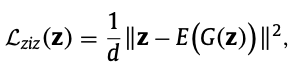



Schemat:


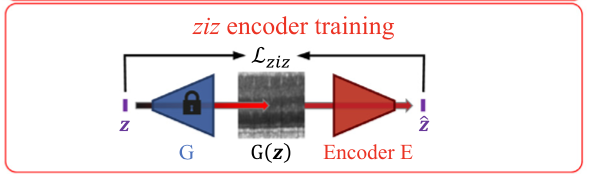



**3.** izif (wykorzystane w kodzie)


Połączenie tych dwóch. Krtyrium jest MSE zarówno w przetrzeni ukrytej jak i przestrzeni zdjęcia. TODO




### 0. Konfiguracja środowiska

In [ ]:
!pip install torchvision==0.8.2

***cd...***

In [ ]:
#repo forked from a03ki for all requirements
!git clone https://github.com/TrybusRafalJan/f-AnoGAN.git

In [ ]:
%cd f-AnoGAN

In [ ]:
!python setup.py install

**Import danych z Kaggle**

In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = 'twmprojekt'
os.environ['KAGGLE_KEY'] = '7cbe815cea0bf6c29fbff1cac69cba0c'

In [ ]:
%%bash
mkdir /content/dataset
cd /content/dataset
kaggle datasets download -d twmprojekt/printedcircutboard --unzip 

### 2.PODLINKOWANIE ODPOWIEDNIEGO ZBIORU DANYCH


Należy podać ścieżkę lokalizacji zbioru danych, ilość sekcji oraz PATH dla każdej zostanie wygenerowany automatycznie

In [ ]:
import time
start_time = time.time()

In [ ]:
data_location = "../dataset/GAN_typeA_whole-ag/GAN_typeA_whole-ag/"
#data_location = "../dataset/GAN_typeA_bySections/GAN_typeA_bySections/"

# Inne możliwe dataset'y
#data_location = "../dataset/GAN_cracks_100/GAN_cracks_100/"
#data_location = "../dataset/GAN_typeA_bySections-ag-invprop/GAN_typeA_bySections-ag-invprop/"
#data_location = "../dataset/GAN_typeC_sections/GAN_typeC_sections/"


In [ ]:
classes_directories = next(os.walk(data_location))[1]
nr_of_sections = len(classes_directories)

classes_directories.sort()
print(classes_directories)
print("\n Identified: ",nr_of_sections, "sections(classes) \n")

train_data_paths = []
test_data_paths = []

for i in range(len(classes_directories)):
  train_path = data_location + "section" + str(i+1) + "/train"
  train_data_paths.append(train_path)

  test_path = data_location + "section" + str(i+1) + "/test"
  test_data_paths.append(test_path)
  

print("\n :::TRAIN DATA PATHS:::")
print(train_data_paths)

print("\n :::TEST DATA PATHS:::")
print(test_data_paths)


### 3. WGAN

**3.1 Funkcje trenujące** WGAN-GP (Wasserstein Distance)(Gradient Penalty)

https://towardsdatascience.com/demystified-wasserstein-gan-with-gradient-penalty-ba5e9b905ead

Algorytm będzie opierał się na próbie zbliżenia dystrybucji generowanych zdjęć (P_g) do dystrybucji prawdziwych zdjęć (P_r) [rys]

Minimalizujemy ten dystans (Wasserstein Distance)

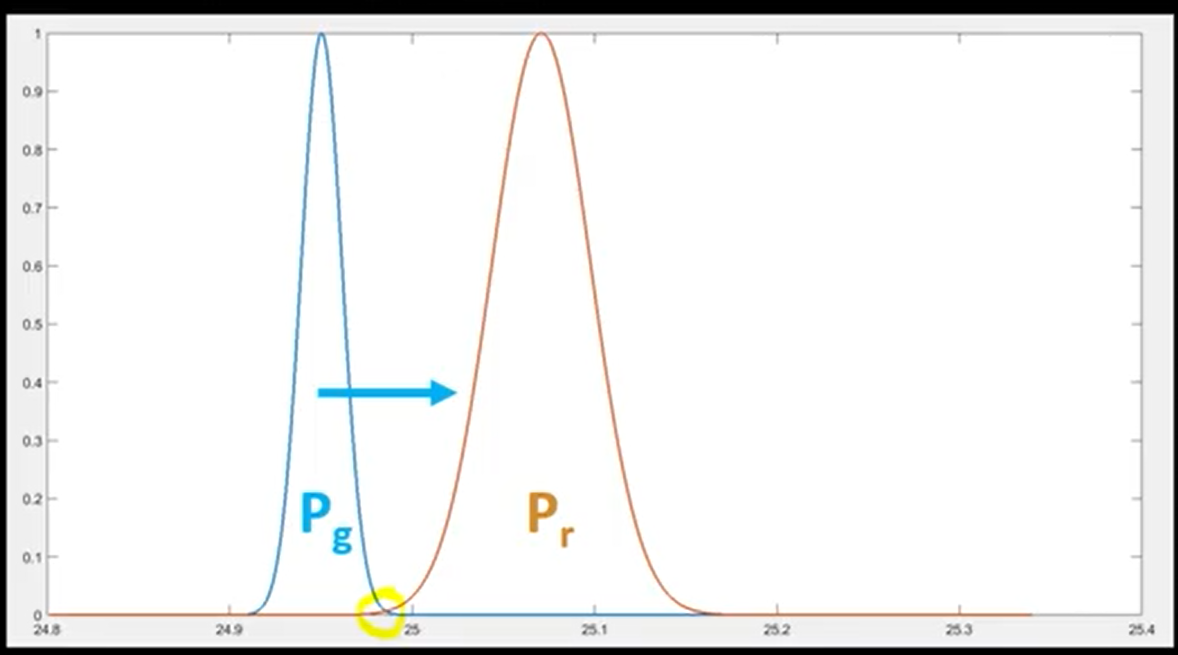

Ograniczenie na dyskryminator realizuja taka funkcja: [rys]


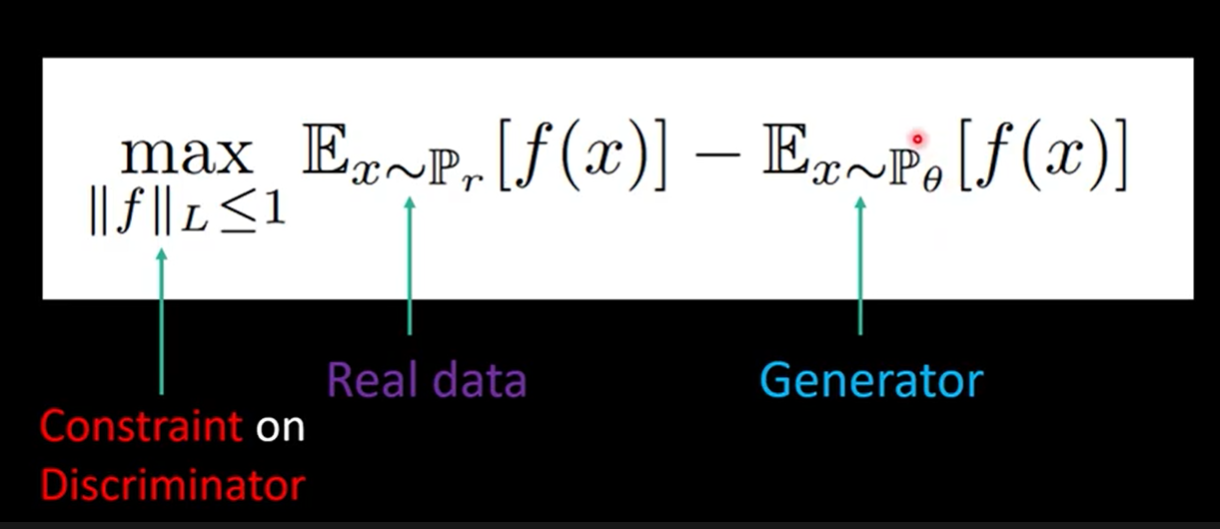

^^ Generator próbuję zbliżyć do siebie P_g i P_r, dyskryminator oddalić


**Funkcje odpowiadające za trening duetu generator , dyskryminator**

In [ ]:
import os
import torch
import torch.autograd as autograd
from torchvision.utils import save_image


def compute_gradient_penalty(D, real_samples, fake_samples, device):
    alpha = torch.rand(*real_samples.shape[:2], 1, 1, device=device)
    interpolates = (alpha * real_samples + (1 - alpha) * fake_samples)
    interpolates = autograd.Variable(interpolates, requires_grad=True)
    d_interpolates = D(interpolates)
    fake = torch.ones(*d_interpolates.shape, device=device)
    gradients = autograd.grad(outputs=d_interpolates, inputs=interpolates,
                              grad_outputs=fake, create_graph=True,
                              retain_graph=True, only_inputs=True)[0]
    gradients = gradients.view(gradients.shape[0], -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty


def train_wgangp(opt, generator, discriminator,dataloader, device, lambda_gp=10,section="none"):
    generator.to(device)
    discriminator.to(device)

    #GENERATOR
    optimizer_G = torch.optim.Adam(generator.parameters(),
                                   lr=opt.lr, betas=(opt.b1, opt.b2))
    #DYSKRIMINATOR
    optimizer_D = torch.optim.Adam(discriminator.parameters(),
                                   lr=opt.lr, betas=(opt.b1, opt.b2))
    k = section
    os.makedirs(f"results/{section}/images", exist_ok=True)

    padding_epoch = len(str(opt.n_epochs))
    padding_i = len(str(len(dataloader)))

    batches_done = 0
    for epoch in range(opt.n_epochs):
        for i, (imgs, _)in enumerate(dataloader):
            real_imgs = imgs.to(device)

            # ---------------------
            #  Trening dyskryminatora
            # ---------------------

            optimizer_D.zero_grad()

            # Wejściem jest wektor szumu
            z = torch.randn(imgs.shape[0], opt.latent_dim, device=device)
            fake_imgs = generator(z)
            real_validity = discriminator(real_imgs)
            fake_validity = discriminator(fake_imgs.detach())

            gradient_penalty = compute_gradient_penalty(discriminator,
                                                        real_imgs.data,
                                                        fake_imgs.data,
                                                        device)

            d_loss = (-torch.mean(real_validity) + torch.mean(fake_validity)
                      + lambda_gp * gradient_penalty)

            d_loss.backward()
            optimizer_D.step()

            optimizer_G.zero_grad()

            if i % opt.n_critic == 0:

                # -----------------
                #  Trening generatora
                # -----------------

                fake_imgs = generator(z)
                fake_validity = discriminator(fake_imgs)
                g_loss = -torch.mean(fake_validity)

                g_loss.backward()
                optimizer_G.step()

                print(f"[Section {section} ]"
                      f"[Epoch {epoch:{padding_epoch}}/{opt.n_epochs}] "
                      f"[Batch {i:{padding_i}}/{len(dataloader)}] "
                      f"[D loss: {d_loss.item():3f}] "
                      f"[G loss: {g_loss.item():3f}]")

                if batches_done % opt.sample_interval == 0:
                    save_image(fake_imgs.data[:25],
                               f"results/{section}/images/{batches_done:06}.png",
                               nrow=5, normalize=True)

                batches_done += opt.n_critic

    torch.save(generator.state_dict(), f"results/{section}/generator")
    torch.save(discriminator.state_dict(), f"results/{section}/discriminator")


**Prosta struktura do przetrzymywania parametrów uczenia**

In [ ]:
class Namespace:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

**Parametry uczenia WGAN'a**

In [ ]:
opt = Namespace(b1=0.5,
                b2=0.999,
                batch_size=32,
                channels=3,
                force_download=False,
                img_size=64,
                latent_dim=100,
                lr=0.0002,
                n_critic=5,
                n_epochs=1500,
                sample_interval=400,
                seed=1)

**3.2. Generator i dyskryminator**

In [ ]:
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, opt):
        super().__init__()

        self.init_size = opt.img_size // 4
        self.l1 = nn.Sequential(nn.Linear(opt.latent_dim,
                                128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, opt.channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img


class Discriminator(nn.Module):
    def __init__(self, opt):
        super().__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1),
                     nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.model = nn.Sequential(
            *discriminator_block(opt.channels, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        ds_size = opt.img_size // 2 ** 4
        self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1))

    def forward(self, img):
        features = self.forward_features(img)
        validity = self.adv_layer(features)
        return validity

    def forward_features(self, img):
        features = self.model(img)
        features = features.view(features.shape[0], -1)
        return features


class Encoder(nn.Module):
    def __init__(self, opt):
        super().__init__()

        def encoder_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1),
                     nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.model = nn.Sequential(
            *encoder_block(opt.channels, 16, bn=False),
            *encoder_block(16, 32),
            *encoder_block(32, 64),
            *encoder_block(64, 128),
        )

        ds_size = opt.img_size // 2 ** 4
        self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2,
                                                 opt.latent_dim),
                                       nn.Tanh())

    def forward(self, img):
        features = self.model(img)
        features = features.view(features.shape[0], -1)
        validity = self.adv_layer(features)
        return validity


Pomocnicza funkcja aplikująca zadane transformacje (data agumentation) na zbiorze zdjęć

In [ ]:
from torchvision.transforms.transforms import GaussianBlur
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import os


from torchvision import datasets, transforms

def agumentData(data_path,mode):
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  if mode == 1:
    transform = transforms.Compose([transforms.Resize([opt.img_size]*2),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.5, 0.5, 0.5],
                                                          [0.5, 0.5, 0.5])])
  elif mode == 2:
      transform = transforms.Compose([transforms.Resize([opt.img_size]*2),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.GaussianBlur(kernel_size=(3, 5), sigma=(0.1, 1)), #
                                      transforms.ColorJitter(brightness=0.3,contrast=0.2,saturation=0.2,hue=0), #
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.5, 0.5, 0.5],
                                                          [0.5, 0.5, 0.5])])

  
  train_dataset = datasets.ImageFolder(data_path, transform=transform)
  nr_of_images = np.shape(train_dataset)[0]
  train_data = torch.utils.data.DataLoader(train_dataset,nr_of_images,True)



  return train_data

Pomocnicza funkcja wyświetlająca zdjęcia (zapisane w obiekcie typu DataLoader) po agumentacji (operacja transform) w postaci siatki:

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL

def imshow(dataLoaderImages,rows,cols):

    dataiter = iter(dataLoaderImages)
    images, labels = dataiter.next()

    images_qty = np.shape(images)
    print("The training data overview: ")
    print("Number of images",images_qty[0])
    print("-------OVERVIEW--------")

    if(rows*cols < images_qty[0]):
      print("The total images QTY is",images_qty[0], " The grid you have selected: ",rows,"x",cols,"=",rows*cols, " is not sufficient. Please specify new ones in the cell above")
    else:
      i = 0
      _, axs = plt.subplots(rows, cols, figsize=(80, 80))
      plt.subplots_adjust(top = 0.59, bottom=0.1, hspace=0.1, wspace=0.1)
      axs = axs.flatten()
    
      for x in range(images_qty[0]):
        images[i] = images[i] / 2 + 0.5
        npimg = images.numpy()
        axs[i].imshow(np.transpose(images[i].numpy(), (1, 2, 0)))
        i = i+1
      plt.show()

Agumentacja i inspekcja zdjęć trenujących

In [ ]:
import math
from collections import Counter

for i in range(nr_of_sections):  
  train_data = agumentData(train_data_paths[i],1)
  
  grid_display_x = 10
  grid_display_y = math.ceil(len(train_data.dataset) / 10)

  print("\n Images display grid: ",[grid_display_x,grid_display_y],"\n")
  print("SECTION [",str(i+1),"/",nr_of_sections,"] \n")
  imshow(train_data,grid_display_x,grid_display_y)

In [ ]:
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import os


from torchvision import datasets, transforms


def main(opt,data_path,section):
    if type(opt.seed) is int:
        torch.manual_seed(opt.seed)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    transform = transforms.Compose([transforms.Resize([opt.img_size]*2),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.5, 0.5, 0.5],
                                                         [0.5, 0.5, 0.5])])

    
    train_dataset = datasets.ImageFolder(data_path, transform=transform)
    train_data = torch.utils.data.DataLoader(train_dataset,32,True)
    
    generator = Generator(opt)
    discriminator = Discriminator(opt)

    train_wgangp(opt, generator, discriminator,
                 train_data, device, section=section)



Trening modeli pod sekcję:

In [ ]:
for i in range(nr_of_sections):
  print("\n BEGGINING WGAN LEARNING FOR SECTION [",str(i+1),"/",nr_of_sections,"] \n")
  main(opt,train_data_paths[i],str(i+1))


Wygenerowane obrazy zapisywane są w `f-AnoGAN/mvtec_ad/results/images`.

**^^ Po powyższych krokach setup potrafi generować 'fake images'**

### 4. DEEP ENCODER

Teraz czas na encoder. Jego zadaniem jest mapowanie zdjęć z powrotem do przestrzeniu ukrytej (latent space) GAN'a.
Ten tutaj działa w oparciu o architekturę *izif*: image-latent-image feature loss


In [ ]:
import os
import torch
import torch.nn as nn
from torchvision.utils import save_image



def train_encoder_izif(opt, generator, discriminator, encoder,
                       dataloader, device, kappa=1.0,section="none"):
    generator.load_state_dict(torch.load(f"results/{section}/generator"))
    discriminator.load_state_dict(torch.load(f"results/{section}/discriminator"))

    generator.to(device).eval()
    discriminator.to(device).eval()
    encoder.to(device)

    criterion = nn.MSELoss()

    optimizer_E = torch.optim.Adam(encoder.parameters(),
                                   lr=opt.lr, betas=(opt.b1, opt.b2))

    os.makedirs(f"results/{section}/images_e", exist_ok=True)

    padding_epoch = len(str(opt.n_epochs))
    padding_i = len(str(len(dataloader)))

    batches_done = 0
    for epoch in range(opt.n_epochs):
        for i, (imgs, _) in enumerate(dataloader):
            real_imgs = imgs.to(device)
            optimizer_E.zero_grad()

            z = encoder(real_imgs)
            fake_imgs = generator(z)

            real_features = discriminator.forward_features(real_imgs)
            fake_features = discriminator.forward_features(fake_imgs)

            # enkoder
            loss_imgs = criterion(fake_imgs, real_imgs)
            loss_features = criterion(fake_features, real_features)
            e_loss = loss_imgs + kappa * loss_features

            e_loss.backward()
            optimizer_E.step()
            
            if i % opt.n_critic == 0:
                print(f"[Section {section} ]"
                      f"[Epoch {epoch:{padding_epoch}}/{opt.n_epochs}] "
                      f"[Batch {i:{padding_i}}/{len(dataloader)}] "
                      f"[E loss: {e_loss.item():3f}]")

                if batches_done % opt.sample_interval == 0:
                    fake_z = encoder(fake_imgs)
                    reconfiguration_imgs = generator(fake_z)
                    save_image(reconfiguration_imgs.data[:25],
                               f"results/{section}/images_e/{batches_done:06}.png",
                               nrow=5, normalize=True)

                batches_done += opt.n_critic
    torch.save(encoder.state_dict(), f"results/{section}/encoder")


In [ ]:
opt = Namespace(b1=0.5,
                b2=0.999,
                batch_size=32,
                channels=3,
                force_download=False,
                img_size=64,
                latent_dim=100,
                lr=0.0002,
                n_critic=5,
                n_epochs=200,
                sample_interval=50,
                seed=1)

In [ ]:
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms




def main(opt,data_path,section):
    if type(opt.seed) is int:
        torch.manual_seed(opt.seed)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    transform = transforms.Compose([transforms.Resize([opt.img_size]*2),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.5, 0.5, 0.5],
                                                         [0.5, 0.5, 0.5])])
    
    train_dataset = datasets.ImageFolder(data_path, transform=transform)
    train_data = torch.utils.data.DataLoader(train_dataset,32,True)

    generator = Generator(opt)
    discriminator = Discriminator(opt)
    encoder = Encoder(opt)

    train_encoder_izif(opt, generator, discriminator, encoder,
                       train_data, device,section=section)


In [ ]:
for i in range(nr_of_sections):
  print("\n BEGGINING DEEP-ENCODER LEARNING FOR SECTION [",str(i+1),"/",nr_of_sections,"] \n")
  main(opt,train_data_paths[i],str(i+1))

### 5. Złożenie f-AnoGAN'a (WGAN + deep enkoder)

Tutaj już część detekcji anomali: połączenie GANA (generator, dyskryminator) z encoderem. I detekcja anomalii.

In [ ]:
opt = Namespace(channels=3,
                force_download=False,
                img_size=64,
                latent_dim=100,
                )

In [ ]:
import torch
import torch.nn as nn
from torch.utils.model_zoo import tqdm


def test_anomaly_detection(opt, generator, discriminator, encoder,
                           dataloader, device, kappa=1.0,section="none"):
    generator.load_state_dict(torch.load(f"results/{section}/generator"))
    discriminator.load_state_dict(torch.load(f"results/{section}/discriminator"))
    encoder.load_state_dict(torch.load(f"results/{section}/encoder"))

    generator.to(device).eval()
    discriminator.to(device).eval()
    encoder.to(device).eval()

    criterion = nn.MSELoss()

    with open(f"results/{section}/score.csv", "w") as f:
        f.write("label,img_distance,anomaly_score,z_distance\n")

    for (img, label) in tqdm(dataloader):

        real_img = img.to(device)

        real_z = encoder(real_img)
        fake_img = generator(real_z)
        fake_z = encoder(fake_img)

        real_feature = discriminator.forward_features(real_img)
        fake_feature = discriminator.forward_features(fake_img)

        img_distance = criterion(fake_img, real_img)
        loss_feature = criterion(fake_feature, real_feature)
        anomaly_score = img_distance + kappa * loss_feature

        z_distance = criterion(fake_z, real_z)

        with open(f"results/{section}/score.csv", "a") as f:
            f.write(f"{label.item()},{img_distance},"
                    f"{anomaly_score},{z_distance}\n")


In [ ]:
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms




def main(opt,data_path,section):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    transform = transforms.Compose([transforms.Resize([opt.img_size]*2),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.5, 0.5, 0.5],
                                                         [0.5, 0.5, 0.5])])
    test_dataset = datasets.ImageFolder(data_path, transform=transform)
    test_data = torch.utils.data.DataLoader(test_dataset,1,False)


    generator = Generator(opt)
    discriminator = Discriminator(opt)
    encoder = Encoder(opt)

    test_anomaly_detection(opt, generator, discriminator, encoder,
                           test_data, device,section=section)

In [ ]:
for i in range(nr_of_sections):
  print("\n BEGGINING ANOMALLY DETECTION LEARNING FOR SECTION [",str(i+1),"/",nr_of_sections,"] \n")
  main(opt,test_data_paths[i],str(i+1))


Wyniki zapisywane są w `f-AnoGAN/mvtec_ad/results`.

### 6. Wyniki

In [ ]:
opt = Namespace(channels=3,
                force_download=False,
                img_size=64,
                latent_dim=100,
                n_grid_lines=10,
                n_iters=0)

In [ ]:
import os
import torch
from torchvision.utils import save_image


def save_compared_images(opt, generator, encoder, dataloader, device,section):
    generator.load_state_dict(torch.load(f"results/{section}/generator"))
    encoder.load_state_dict(torch.load(f"results/{section}/encoder"))

    generator.to(device).eval()
    encoder.to(device).eval()

    os.makedirs(f"results/{section}/images_diff", exist_ok=True)

    for i, (img, label) in enumerate(dataloader):
        real_img = img.to(device)

        real_z = encoder(real_img)
        fake_img = generator(real_z)

        compared_images = torch.empty(real_img.shape[0] * 3,
                                      *real_img.shape[1:])
        compared_images[0::3] = real_img
        compared_images[1::3] = fake_img
        compared_images[2::3] = real_img - fake_img

        save_image(compared_images.data,
                   f"results/{section}/images_diff/{opt.n_grid_lines*(i+1):06}.png",
                   nrow=3, normalize=True)

        if opt.n_iters is not None and opt.n_iters == i:
            break


In [ ]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

def main(opt,data_path,section):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    transform = transforms.Compose([transforms.Resize([opt.img_size]*2),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.5, 0.5, 0.5],
                                                         [0.5, 0.5, 0.5])])
    
    test_dataset = datasets.ImageFolder(data_path, transform=transform)
    test_data = torch.utils.data.DataLoader(test_dataset,opt.n_grid_lines,False)

    

    generator = Generator(opt)
    encoder = Encoder(opt)

    save_compared_images(opt, generator, encoder, test_data, device,section=section)

In [ ]:
for i in range(nr_of_sections):
  print("\n SAVING COMPARED IMAGES (OK & NOK) FOR SECTION [",str(i+1),"/",nr_of_sections,"] \n")
  main(opt,test_data_paths[i],str(i+1))


Porównane obrazy zapisywane są w `f-AnoGAN/mvtec_ad/results/images_diff`.


### Wizualizacja



In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve,  precision_recall_curve, auc

In [ ]:
from IPython.display import display 
for i in range(nr_of_sections):
  df = pd.read_csv(f"results/{str(i+1)}/score.csv")
  print(f"SECTION {str(i+1)} RESULTS (in CSV):")
  display(df) 


In [ ]:
training_label = 1

for i in range(nr_of_sections):
  df = pd.read_csv(f"results/{str(i+1)}/score.csv")
  labels = np.where(df["label"].values == training_label, 0, 1)
  anomaly_score = df["anomaly_score"].values
  img_distance = df["img_distance"].values
  z_distance = df["z_distance"].values

  fpr, tpr, _ = roc_curve(labels, img_distance)
  precision, recall, _ = precision_recall_curve(labels, img_distance)
  roc_auc = auc(fpr, tpr)
  pr_auc =  auc(recall, precision)


  print("\n :::SECTION [",str(i+1),"/",nr_of_sections,"]::: \n")
  print("\n ROC-Curve")
  plt.figure(figsize=(6, 4), dpi=80)
  plt.plot(fpr, tpr, label=f"AUC = {roc_auc:3f}")
  plt.plot([0, 1], [0, 1], linestyle="--")
  plt.title("ROC-Curve")
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.legend()
  plt.show()

  print("\n PR-Curve")
  plt.figure(figsize=(6, 4), dpi=80)
  plt.plot(recall, precision, label=f" AUC = {pr_auc:3f}")
  plt.title("PR-Curve")
  plt.xlabel("Recall")
  plt.ylabel("Pecision")
  plt.legend()
  plt.show()

  print("NORMAL VS ABNORMAL DISTRIBUTION")
  plt.figure(figsize=(6, 4), dpi=80)

  plt.hist([anomaly_score[labels == 0], anomaly_score[labels == 1]],
            bins=40, density=True, stacked=True,
            label=["Klasa OK", "Klasa NOK"])
  plt.xlabel("Anomaly scores A(x)")
  plt.ylabel("h")
  plt.legend()
  plt.show()
  

## Compared Images

In [ ]:
from PIL import Image
import os
import time
for i in range(nr_of_sections):

  print("SECTION [",str(i+1),"/",nr_of_sections,"] IMAGE DIFF")
  im = Image.open(f"results/{str(i+1)}/images_diff/000010.png")
  
  plt.rcParams["figure.figsize"] = [10, 10]
  plt.imshow(im,extent=[-60, 60, -80, 80],aspect="auto")
  plt.show()

In [ ]:
stop_time = time.time()

In [ ]:
print(f'stop_time-start_time')
print(f'Czas w minutach: {(stop_time-start_time)/60}')

In [ ]:
section_idx = input(f"Select section to inspect: 1-{str(nr_of_sections)} and click ENTER \n")

if(int(section_idx) > nr_of_sections):
  section_idx = input(f"Select section to inspect: 1-{str(nr_of_sections)} and click ENTER \n")
  
k = section_idx
Image.open(f"results/{k}/images_diff/000010.png")

In [ ]:
!zip -r /content/file.zip /content/f-AnoGAN/exported_model/

In [ ]:
from google.colab import files
files.download("/content/file.zip")